# 라이브러리

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import xgboost as xgb

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [4]:
# 파일 경로 설정
file_path = '../data/'

# 파일 불러오기
df = pd.read_csv(file_path + 'final.csv')
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')

In [5]:
# train, test split

train_data = df[df["_type"] == "train"]
test_data = df[df["_type"] == "test"]

In [7]:
data = train_data['deposit']

# bins = [0, 15000, 25000, 40000, 400000, 1000000]
# bins = [0, 15000, 22000, 35000, 400000, 1000000]
# bins = [0, 15000, 22000, 30000, 400000, 1000000]
# bins = [0, 15000, 25000, 35000, 400000, 1000000]
# bins = [0, 18000, 30000, 50000, 400000, 1000000]

# 각 구간별 데이터프레임 생성

train_data_0_20k = train_data[(data > 0) & (data <= 15000)]
train_data_20k_30k = train_data[(data > 15000) & (data <= 22000)]
train_data_30k_45k = train_data[(data > 22000) & (data <= 30000)]
train_data_50k_150k = train_data[(data > 30000) & (data <= 400000)]
train_data_150k_1M = train_data[(data > 400000) & (data <= 1000000)]

# 변수 선택

In [8]:
columns = ['area_m2', 'floor',
       'built_year', 'latitude', 'longitude',
       'previous_month_interest_rate', 'monthly_new_supply',
       'complex_id', 'max_deposit', 'cluster_labels',
       'contract_year', 'contract_month',
       'mean_deposit_per_area_year',
       'max_deposit_per_area',
       'previous_deposit2',
       'half_max_deposit',
       'deposit_std_id',
       'nearest_subway_distance_km', 'nearest_elementary_distance_km',
       'nearest_middle_distance_km', 'nearest_high_distance_km',
       'nearest_park_distance_km', 'nearest_park_area',
       'num_subway_within_0_5', 'num_subway_within_1', 'num_subway_within_2',
       'num_elementary_within_0_5', 'num_elementary_within_1',
       'num_elementary_within_2', 'num_middle_within_0_5',
       'num_middle_within_1', 'num_middle_within_2', 'num_high_within_0_5',
       'num_high_within_1', 'num_high_within_2', 'num_park_within_0_8',
       'num_park_within_1_5', 'num_park_within_2',
       'area_floor_interaction',
       'nearest_transportation_hub',
       'contract_type'
      ]

# 데이터셋 분할 (holdout, K-fold, TimeSeriesSplit)

### holdout

In [9]:
# Holdout 기간 설정
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & 
                           (train_data['contract_year_month'] <= holdout_end)]

# 전체 데이터에서 holdout 데이터를 제외한 나머지 데이터
train_data_remaining = train_data[~((train_data['contract_year_month'] >= holdout_start) & 
                                     (train_data['contract_year_month'] <= holdout_end))]
# 각 분위 조건을 설정합니다.
holdout_data_0_20k = train_data_0_20k[(train_data_0_20k['contract_year_month'] >= holdout_start) & (train_data_0_20k['contract_year_month'] <= holdout_end)]
holdout_data_20k_30k = train_data_20k_30k[(train_data_20k_30k['contract_year_month'] >= holdout_start) & (train_data_20k_30k['contract_year_month'] <= holdout_end)]
holdout_data_30k_45k = train_data_30k_45k[(train_data_30k_45k['contract_year_month'] >= holdout_start) & (train_data_30k_45k['contract_year_month'] <= holdout_end)]
holdout_data_50k_150k = train_data_50k_150k[(train_data_50k_150k['contract_year_month'] >= holdout_start) & (train_data_50k_150k['contract_year_month'] <= holdout_end)]
holdout_data_150k_1M = train_data_150k_1M[(train_data_150k_1M['contract_year_month'] >= holdout_start) & (train_data_150k_1M['contract_year_month'] <= holdout_end)]

# 각 구간별 데이터프레임 생성
train_data_0_20k = train_data_0_20k[~((train_data_0_20k['contract_year_month'] >= holdout_start) & (train_data_0_20k['contract_year_month'] <= holdout_end))]
train_data_20k_30k = train_data_20k_30k[~((train_data_20k_30k['contract_year_month'] >= holdout_start) & (train_data_20k_30k['contract_year_month'] <= holdout_end))]
train_data_30k_45k = train_data_30k_45k[~((train_data_30k_45k['contract_year_month'] >= holdout_start) & (train_data_30k_45k['contract_year_month'] <= holdout_end))]
train_data_50k_150 = train_data_50k_150k[~((train_data_50k_150k['contract_year_month'] >= holdout_start) & (train_data_50k_150k['contract_year_month'] <= holdout_end))]
train_data_150k_1M = train_data_150k_1M[~((train_data_150k_1M['contract_year_month'] >= holdout_start) & (train_data_150k_1M['contract_year_month'] <= holdout_end))]

In [10]:
X_train = train_data_remaining[columns]
y_train = train_data_remaining['deposit']

X_train_0_20k = train_data_0_20k[columns]
y_train_0_20k = train_data_0_20k['deposit']

X_train_20k_30k = train_data_20k_30k[columns]
y_train_20k_30k = train_data_20k_30k['deposit']

X_train_30k_45k = train_data_30k_45k[columns]
y_train_30k_45k = train_data_30k_45k['deposit']

X_train_50k_150k = train_data_50k_150k[columns]
y_train_50k_150k = train_data_50k_150k['deposit']

X_train_150k_1M = train_data_150k_1M[columns]
y_train_150k_1M = train_data_150k_1M['deposit']

# Holdout 데이터 분리
X_holdout = holdout_data[columns]
y_holdout = holdout_data['deposit']

X_holdout_0_20k = holdout_data_0_20k[columns]
y_holdout_0_20k = holdout_data_0_20k['deposit']

X_holdout_20k_30k = holdout_data_20k_30k[columns]
y_holdout_20k_30k = holdout_data_20k_30k['deposit']

X_holdout_30k_45k = holdout_data_30k_45k[columns]
y_holdout_30k_45k = holdout_data_30k_45k['deposit']

X_holdout_50k_150k = holdout_data_50k_150k[columns]
y_holdout_50k_150k = holdout_data_50k_150k['deposit']

X_holdout_150k_1M = holdout_data_150k_1M[columns]
y_holdout_150k_1M = holdout_data_150k_1M['deposit']

# 테스트 데이터 (예를 들어, test_data를 사용)
X_test = test_data[columns].copy()

# 모델링 (DNN, GBM, Transformer)

## LGBM

In [11]:
import lightgbm as lgb

def train_lgb_model(X_train, y_train):
    model = lgb.LGBMRegressor(
        learning_rate=0.15,
        max_depth=30,
        n_estimators=200,
        num_leaves=30,
        min_child_samples=50,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.4,
        random_state=RANDOM_SEED
    )
    model.fit(X_train, y_train)
    return model



lgb_model = train_lgb_model(X_train, y_train)
lgb_model_0_20k = train_lgb_model(X_train_0_20k, y_train_0_20k)
lgb_model_20k_30k = train_lgb_model(X_train_20k_30k, y_train_20k_30k)
lgb_model_30k_45k= train_lgb_model(X_train_30k_45k, y_train_30k_45k)
lgb_model_50k_150k = train_lgb_model(X_train_50k_150k, y_train_50k_150k)
lgb_model_150k_1M = train_lgb_model(X_train_150k_1M, y_train_150k_1M)

# 모델 학습 결과 확인 (예: 모델 파라미터 출력)
print("Model for 0 < deposit <= 20k:", lgb_model)
print("Model for 0 < deposit <= 20k:", lgb_model_0_20k)
print("Model for 20k < deposit <= 50k:", lgb_model_20k_30k)
print("Model for 20k < deposit <= 50k:", lgb_model_30k_45k)
print("Model for 50k < deposit <= 150k:", lgb_model_50k_150k)
print("Model for 150k < deposit <= 1M:", lgb_model_150k_1M)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5475
[LightGBM] [Info] Number of data points in the train set: 1082981, number of used features: 41
[LightGBM] [Info] Start training from score 36939.997355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5405
[LightGBM] [Info] Number of data points in the train set: 133126, number of used features: 41
[LightGBM] [Info] Start training from score 11424.408756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [12]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return mae, rmse

# Holdout 데이터에 대한 예측 및 성능 평가
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae, lgb_holdout_rmse = calculate_metrics(y_holdout, lgb_holdout_pred)

lgb_holdout_pred_0_20k = lgb_model_0_20k.predict(X_holdout_0_20k)
lgb_holdout_mae_0_20k, lgb_holdout_rmse_0_20k = calculate_metrics(y_holdout_0_20k, lgb_holdout_pred_0_20k)

lgb_holdout_pred_20k_30k = lgb_model_20k_30k.predict(X_holdout_20k_30k)
lgb_holdout_mae_20k_30k, lgb_holdout_rmse_20k_30k = calculate_metrics(y_holdout_20k_30k, lgb_holdout_pred_20k_30k)

lgb_holdout_pred_30k_45k = lgb_model_30k_45k.predict(X_holdout_30k_45k)
lgb_holdout_mae_30k_45k, lgb_holdout_rmse_30k_45k = calculate_metrics(y_holdout_30k_45k, lgb_holdout_pred_30k_45k)

lgb_holdout_pred_50k_150k = lgb_model_50k_150k.predict(X_holdout_50k_150k)
lgb_holdout_mae_50k_150k, lgb_holdout_rmse_50k_150k = calculate_metrics(y_holdout_50k_150k, lgb_holdout_pred_50k_150k)

lgb_holdout_pred_150k_1M = lgb_model_150k_1M.predict(X_holdout_150k_1M)
lgb_holdout_mae_150k_1M, lgb_holdout_rmse_150k_1M = calculate_metrics(y_holdout_150k_1M, lgb_holdout_pred_150k_1M)

# 성능 출력
print("Holdout 데이터셋 성능")
print(f"all deposit - LightGBM MAE: {lgb_holdout_mae:.2f}, RMSE: {lgb_holdout_rmse:.2f}")
print(f"0 < deposit <= 20k - LightGBM MAE: {lgb_holdout_mae_0_20k:.2f}, RMSE: {lgb_holdout_rmse_0_20k:.2f}")
print(f"20k < deposit <= 50k - LightGBM MAE: {lgb_holdout_mae_20k_30k:.2f}, RMSE: {lgb_holdout_rmse_20k_30k:.2f}")
print(f"20k < deposit <= 50k - LightGBM MAE: {lgb_holdout_mae_30k_45k:.2f}, RMSE: {lgb_holdout_rmse_30k_45k:.2f}")
print(f"50k < deposit <= 150k - LightGBM MAE: {lgb_holdout_mae_50k_150k:.2f}, RMSE: {lgb_holdout_rmse_50k_150k:.2f}")
print(f"150k < deposit <= 1M - LightGBM MAE: {lgb_holdout_mae_150k_1M:.2f}, RMSE: {lgb_holdout_rmse_150k_1M:.2f}")


Holdout 데이터셋 성능
all deposit - LightGBM MAE: 3472.16, RMSE: 5422.57
0 < deposit <= 20k - LightGBM MAE: 848.06, RMSE: 1169.57
20k < deposit <= 50k - LightGBM MAE: 997.67, RMSE: 1301.62
20k < deposit <= 50k - LightGBM MAE: 1391.16, RMSE: 1747.10
50k < deposit <= 150k - LightGBM MAE: 3704.67, RMSE: 5515.45
150k < deposit <= 1M - LightGBM MAE: 107635.47, RMSE: 135649.16


In [13]:
X_train = train_data_remaining[columns]
y_train = train_data_remaining['deposit']

X_train_0_20k = train_data_0_20k[columns]
y_train_0_20k = train_data_0_20k['deposit']

X_train_20k_30k = train_data_20k_30k[columns]
y_train_20k_30k = train_data_20k_30k['deposit']

X_train_30k_45k = train_data_30k_45k[columns]
y_train_30k_45k = train_data_30k_45k['deposit']

X_train_50k_150k = train_data_50k_150k[columns]
y_train_50k_150k = train_data_50k_150k['deposit']

X_train_150k_1M = train_data_150k_1M[columns]
y_train_150k_1M = train_data_150k_1M['deposit']

# Holdout 데이터 분리
X_holdout = holdout_data[columns]
y_holdout = holdout_data['deposit']

X_holdout_0_20k = holdout_data_0_20k[columns]
y_holdout_0_20k = holdout_data_0_20k['deposit']

X_holdout_20k_30k = holdout_data_20k_30k[columns]
y_holdout_20k_30k = holdout_data_20k_30k['deposit']

X_holdout_30k_45k = holdout_data_30k_45k[columns]
y_holdout_30k_45k = holdout_data_30k_45k['deposit']

X_holdout_50k_150k = holdout_data_50k_150k[columns]
y_holdout_50k_150k = holdout_data_50k_150k['deposit']

X_holdout_150k_1M = holdout_data_150k_1M[columns]
y_holdout_150k_1M = holdout_data_150k_1M['deposit']

# 테스트 데이터 (예를 들어, test_data를 사용)
X_test = test_data[columns].copy()

In [14]:
# 전체 데이터셋 결합
full_X = pd.concat([X_train, X_holdout])
full_y = pd.concat([y_train, y_holdout])

full_X_0_20k = pd.concat([X_train_0_20k, X_holdout_0_20k])
full_y_0_20k = pd.concat([y_train_0_20k, y_holdout_0_20k])

full_X_20k_30k = pd.concat([X_train_20k_30k, X_holdout_20k_30k])
full_y_20k_30k = pd.concat([y_train_20k_30k, y_holdout_20k_30k])

full_X_30k_45k = pd.concat([X_train_30k_45k, X_holdout_30k_45k])
full_y_30k_45k = pd.concat([y_train_30k_45k, y_holdout_30k_45k])

full_X_50k_150k = pd.concat([X_train_50k_150k, X_holdout_50k_150k])
full_y_50k_150k = pd.concat([y_train_50k_150k, y_holdout_50k_150k])

full_X_150k_1M = pd.concat([X_train_150k_1M, X_holdout_150k_1M])
full_y_150k_1M = pd.concat([y_train_150k_1M, y_holdout_150k_1M])

# 전체 데이터셋
full_d = pd.concat([train_data, holdout_data])

In [15]:
# LightGBM 모델 초기화
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=30,
    n_estimators=200,
    num_leaves=30,
    min_child_samples=50,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.4,
    random_state=42
)

# 전체 데이터에 대한 학습 및 예측
lgb_model.fit(full_X, full_y)
y_pred_full = lgb_model.predict(full_X)

mae_full = mean_absolute_error(full_y, y_pred_full)
print(f"전체 데이터셋에 대한 Mean Absolute Error (MAE): {mae_full:.4f}")

# 각 구간별 모델 학습 및 예측
# 0 < deposit <= 20k
lgb_model_0_20k = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=30,
    n_estimators=200,
    num_leaves=30,
    min_child_samples=50,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.4,
    random_state=42
)

lgb_model_0_20k.fit(full_X_0_20k, full_y_0_20k)
y_pred_0_20k = lgb_model_0_20k.predict(full_X_0_20k)
mae_0_20k = mean_absolute_error(full_y_0_20k, y_pred_0_20k)
print(f"0 < deposit <= 20k의 Mean Absolute Error (MAE): {mae_0_20k:.4f}")

# 20k < deposit <= 50k
lgb_model_20k_30k = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=30,
    n_estimators=200,
    num_leaves=30,
    min_child_samples=50,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.4,
    random_state=42
)

lgb_model_20k_30k.fit(full_X_20k_30k, full_y_20k_30k)
y_pred_20k_30k = lgb_model_20k_30k.predict(full_X_20k_30k)
mae_20k_30k = mean_absolute_error(full_y_20k_30k, y_pred_20k_30k)
print(f"20k < deposit <= 30k의 Mean Absolute Error (MAE): {mae_20k_30k:.4f}")

lgb_model_30k_45k = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=30,
    n_estimators=200,
    num_leaves=30,
    min_child_samples=50,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.4,
    random_state=42
)

lgb_model_30k_45k.fit(full_X_30k_45k, full_y_30k_45k)
y_pred_30k_45k = lgb_model_30k_45k.predict(full_X_30k_45k)
mae_30k_45k = mean_absolute_error(full_y_30k_45k, y_pred_30k_45k)
print(f"30k < deposit <= 45k의 Mean Absolute Error (MAE): {mae_30k_45k:.4f}")
# 50k < deposit <= 150k
lgb_model_50k_150k = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=30,
    n_estimators=200,
    num_leaves=30,
    min_child_samples=50,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.4,
    random_state=42
)

# lgb_model_50k_150k = lgb.LGBMRegressor(
#         learning_rate=0.3,  # 높임
#         max_depth=50,       # 깊이 증가
#         n_estimators=500,   # 트리 수 증가
#         num_leaves=50,      # 리프 수 증가
#         min_child_samples=5,  # 샘플 수 감소
#         min_child_weight=0.1,  # 가중치 감소
#         colsample_bytree=0.5,  # 특성 비율 감소
#         subsample=0.2,
#         random_state=42
# )

lgb_model_50k_150k.fit(full_X_50k_150k, full_y_50k_150k)
y_pred_50k_150k = lgb_model_50k_150k.predict(full_X_50k_150k)
mae_50k_150k = mean_absolute_error(full_y_50k_150k, y_pred_50k_150k)
print(f"50k < deposit <= 150k의 Mean Absolute Error (MAE): {mae_50k_150k:.4f}")

# 150k < deposit <= 1M
lgb_model_150k_1M = lgb.LGBMRegressor(
    learning_rate=0.15,
    max_depth=30,
    n_estimators=200,
    num_leaves=30,
    min_child_samples=50,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.4,
    random_state=42
)
# lgb_model_150k_1M = lgb.LGBMRegressor(
#         learning_rate=0.3,  # 높임
#         max_depth=50,       # 깊이 증가
#         n_estimators=500,   # 트리 수 증가
#         num_leaves=50,      # 리프 수 증가
#         min_child_samples=5,  # 샘플 수 감소
#         min_child_weight=0.1,  # 가중치 감소
#         colsample_bytree=0.5,  # 특성 비율 감소
#         subsample=0.2,
#         random_state=42
# )
lgb_model_150k_1M.fit(full_X_150k_1M, full_y_150k_1M)
y_pred_150k_1M = lgb_model_150k_1M.predict(full_X_150k_1M)
mae_150k_1M = mean_absolute_error(full_y_150k_1M, y_pred_150k_1M)
print(f"150k < deposit <= 1M의 Mean Absolute Error (MAE): {mae_150k_1M:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 1277004, number of used features: 41
[LightGBM] [Info] Start training from score 37563.490127
전체 데이터셋에 대한 Mean Absolute Error (MAE): 3276.0106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5412
[LightGBM] [Info] Number of data points in the train set: 149920, number of used features: 41
[LightGBM] [Info] Start training from score 11487.989428
0 < deposit <= 20k의 Mean Absolute Error (MAE): 722.7431
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

In [16]:
# 전체 테스트 데이터에 대한 예측
lgb_test_pred_full = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred_full
sample_submission.to_csv('output_full.csv', index=False, encoding='utf-8-sig')

# 각 구간별로 동일한 X_test를 사용하여 예측
# 0 < deposit <= 20k
lgb_test_pred_0_20k = lgb_model_0_20k.predict(X_test)
sample_submission_0_20k = sample_submission.copy()
sample_submission_0_20k['deposit'] = lgb_test_pred_0_20k
sample_submission_0_20k.to_csv('output_0_20k.csv', index=False, encoding='utf-8-sig')

# 20k < deposit <= 50k
lgb_test_pred_20k_30k = lgb_model_20k_30k.predict(X_test)
sample_submission_20k_30k = sample_submission.copy()
sample_submission_20k_30k['deposit'] = lgb_test_pred_20k_30k
sample_submission_20k_30k.to_csv('output_20k_30k.csv', index=False, encoding='utf-8-sig')

# 20k < deposit <= 50k
lgb_test_pred_30k_45k = lgb_model_30k_45k.predict(X_test)
sample_submission_30k_45k = sample_submission.copy()
sample_submission_30k_45k['deposit'] = lgb_test_pred_30k_45k
sample_submission_30k_45k.to_csv('output_30k_45k.csv', index=False, encoding='utf-8-sig')
# 50k < deposit <= 150k

lgb_test_pred_50k_150k = lgb_model_50k_150k.predict(X_test)
sample_submission_50k_150k = sample_submission.copy()
sample_submission_50k_150k['deposit'] = lgb_test_pred_50k_150k
sample_submission_50k_150k.to_csv('output_50k_150k.csv', index=False, encoding='utf-8-sig')

# 150k < deposit <= 1M
lgb_test_pred_150k_1M = lgb_model_150k_1M.predict(X_test)
sample_submission_150k_1M = sample_submission.copy()
sample_submission_150k_1M['deposit'] = lgb_test_pred_150k_1M
sample_submission_150k_1M.to_csv('output_150k_1M.csv', index=False, encoding='utf-8-sig')


/data/ephemeral/home/level2-competitiveds-recsys-05/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


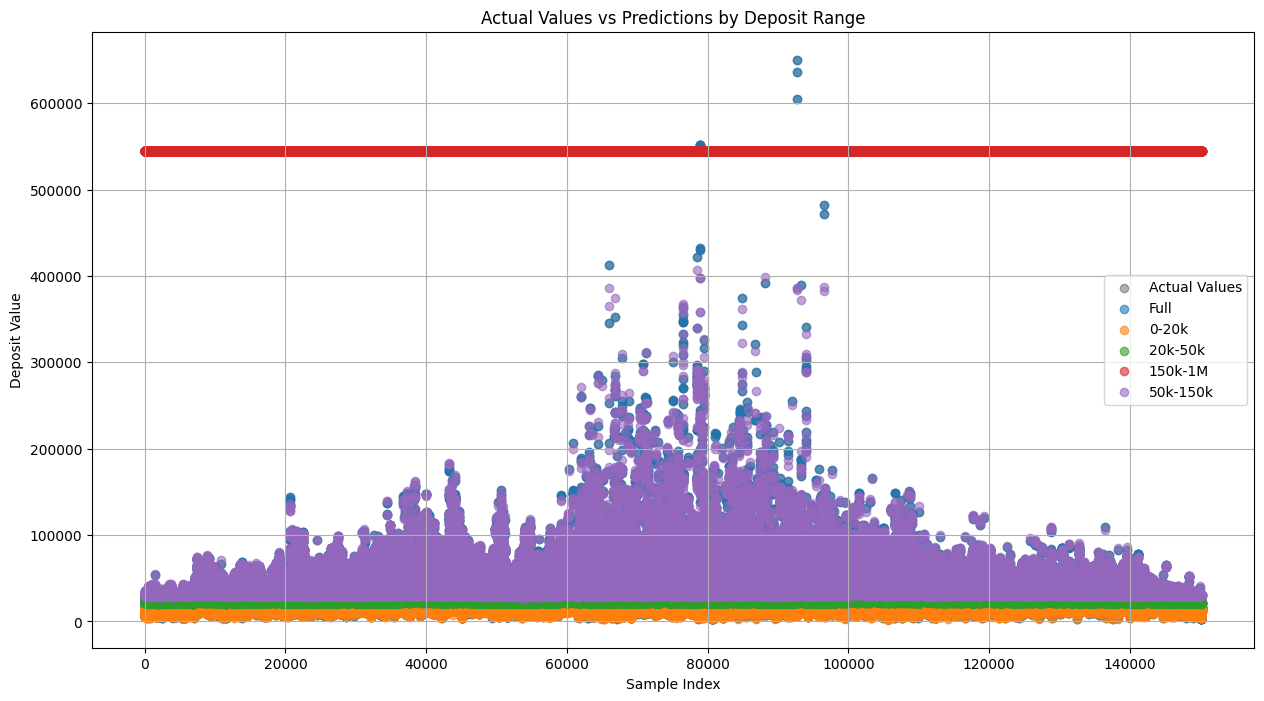

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 각 구간별 예측값
predictions = {
    'Full': lgb_test_pred_full,
    '0-20k': lgb_test_pred_0_20k,
    '20k-50k': lgb_test_pred_20k_30k,
    '20k-50k': lgb_test_pred_30k_45k,
    '150k-1M': lgb_test_pred_150k_1M,
    '50k-150k': lgb_test_pred_50k_150k
}

# 실제 값
actual_values = sample_submission['deposit'].values

# x축 값 생성 (예시로 인덱스를 사용)
x = np.arange(len(X_test))

# 그래프 그리기
plt.figure(figsize=(15, 8))

# 실제 값 먼저 그리기
plt.scatter(x, actual_values, color='black', label='Actual Values', alpha=0.3)

# 각 구간별 예측값
for label, preds in predictions.items():
    plt.scatter(x, preds, label=label, alpha=0.6)

plt.title('Actual Values vs Predictions by Deposit Range')
plt.xlabel('Sample Index')
plt.ylabel('Deposit Value')
plt.legend()
plt.grid()
plt.show()


train_data_0_20k = train_data[(data > 0) & (data <= 20000)]
train_data_20k_30k = train_data[(data > 20000) & (data <= 50000)]
train_data_30k_45k = train_data[(data > 50000) & (data <= 150000)]
train_data_50k_150k = train_data[(data > 150000) & (data <= 400000)]
train_data_150k_1M = train_data[(data > 400000) & (data <= 1000000)]

In [18]:
lgb_test_pred_full = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred_full
# bins = [0, 15000, 25000, 40000, 400000, 1000000]

#bins = [0, 15000, 22000, 35000, 400000, 1000000]
# bins = [0, 15000, 22000, 30000, 400000, 1000000]
#bins = [0, 15000, 25000, 35000, 400000, 1000000]
# bins = [0, 18000, 30000, 50000, 400000, 1000000]
# 각 구간에 따른 조건 설정
conditions = [
    (sample_submission['deposit'] > 0) & (sample_submission['deposit'] <= 15000),
    (sample_submission['deposit'] > 15000) & (sample_submission['deposit'] <= 22000),
    (sample_submission['deposit'] > 22000) & (sample_submission['deposit'] <= 30000),
    (sample_submission['deposit'] > 30000) & (sample_submission['deposit'] <= 400000),
    (sample_submission['deposit'] > 400000) & (sample_submission['deposit'] <= 1000000)
]

# 각 구간에 따른 모델 예측값
predictions = [
    lgb_model_0_20k.predict(X_test),    # 0 < deposit <= 20k
    lgb_model_20k_30k.predict(X_test),    # 0 < deposit <= 20k
    lgb_model_30k_45k.predict(X_test), # 20k < deposit <= 50k
    lgb_model_50k_150k.predict(X_test), # 50k < deposit <= 150k
    lgb_model_150k_1M.predict(X_test)   # 150k < deposit <= 1M
]

# 전체 예측값에 따라 해당 모델 예측값으로 대체
final_predictions = np.select(conditions, predictions, default=lgb_test_pred_full)

# 결과를 sample_submission에 저장
sample_submission['deposit'] = final_predictions
sample_submission.to_csv('output_final.csv', index=False, encoding='utf-8-sig')

In [20]:
df3 = pd.read_csv(file_path + 'output_ojh.csv')

In [21]:
tmp = pd.DataFrame()
tmp['index'] = test_data['index']
tmp['deposit'] = final_predictions
#tmp['deposit'] =lgb_test_pred_full
tmp = tmp.sort_values(by='index')

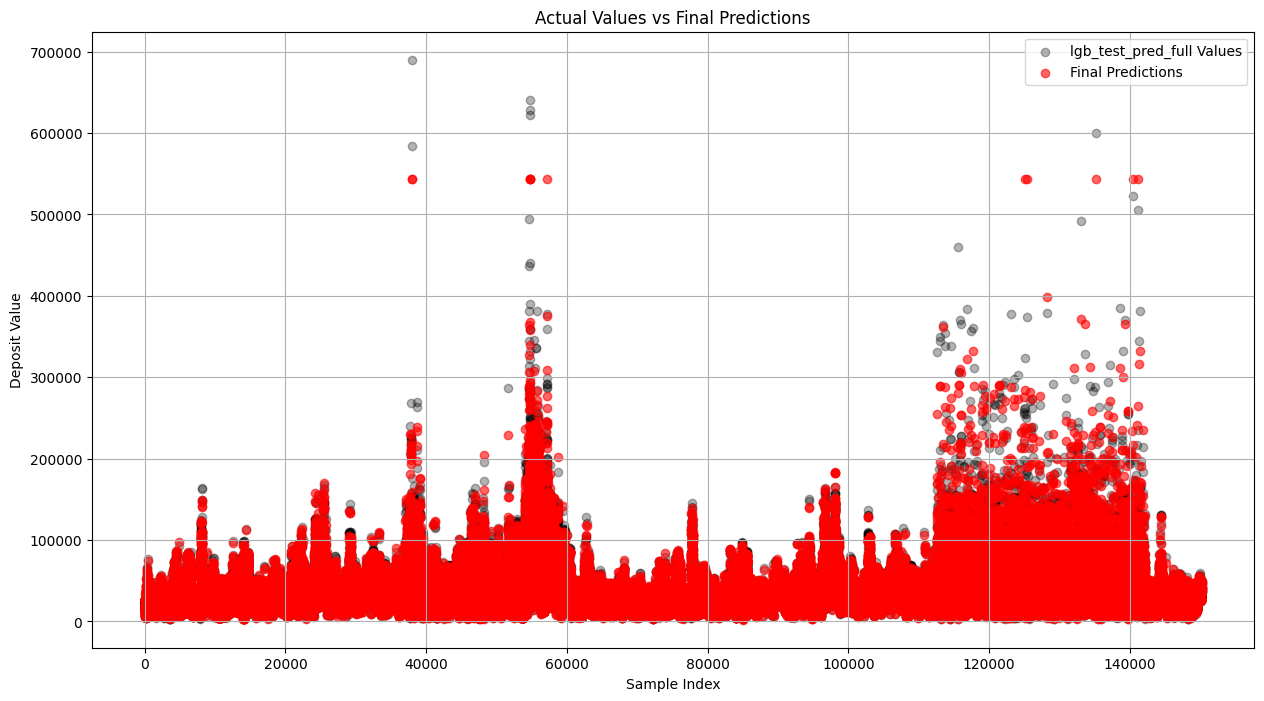

In [22]:
# 최종 예측값 (대체된 값)
final_predictions = sample_submission['deposit'].values

# 실제 값
actual_values = df3['deposit'].values

# x축 값 생성 (예시로 인덱스를 사용)
x = np.arange(len(X_test))

# 그래프 그리기
plt.figure(figsize=(15, 8))

# 실제 값 그리기
plt.scatter(x, actual_values, color='black', label='well_pred_output_csv', alpha=0.3)

# 최종 예측값 그리기
plt.scatter(x, tmp['deposit'], color='red', label='Final Predictions', alpha=0.6)

plt.title('Actual Values vs Final Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Deposit Value')
plt.legend()
plt.grid()
plt.show()


In [24]:
tmp.to_csv('output.csv')